In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm

In [2]:
from utils_1d_case_slope_const.data_gen_1d import generate_laplace_data, create_dataloaders
from utils_1d_case_slope_const.misc_utils import transformation_laplace_to_std_normal, plot_transformation
from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from utils_1d_case_slope_const.plot_1d_case import plot_with_annotations, plot_multiple_histogram

# training_qd_sc constaines the Model trainer class
from utils_1d_case_slope_const.training_1d_sc import train_and_evaluate, ModelTrainer
from utils_1d_case_slope_const.training_analysis import analyse_training

In [3]:
# GENERATE LAPLACE DATA
mean , scale = 5,6
total_samples = 70000

train_data, val_data, test_data = generate_laplace_data(mean, scale, total_samples)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 32#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)


Train size: 52500, Val size: 17500, Test size: 15000


In [4]:
SIZE=351;RANGE=20; START_VAL=-20; END_VAL=25
mu, b = mean, scale

# SIZE=51;RANGE=20; START_VAL=-20; END_VAL=30
# mu, b = mean, scale

In [5]:
GRID_VALS, FN_INIT = transformation_laplace_to_std_normal(
            mu=mu, b=b, x_range=(START_VAL, END_VAL), num_points=SIZE
        )

# trying the weighted TV2 regularisation and see if it leads to some improvement or not.

In [6]:
# calculating weights (for the case of laplace distribution)
# laplace_dist= torch.distributions.Laplace(mu, b)
# wts= laplace_dist.log_prob(torch.tensor(GRID_VALS[1:])).exp()#(GRID_VALS[1:])

In [7]:
# trainer, with wtd avg case
# trainer = ModelTrainer(size=SIZE, range_=RANGE, start_val=START_VAL, end_val=END_VAL,wtd_tv2=1,
#                        weights=wts,
#                  GRID_VALS=GRID_VALS, FN_INIT=FN_INIT, mu=mu, b=b)
# trainer.model

In [8]:
# trainer.before_training_plot(train_data=train_data, annotate=0)

In [9]:
# run the trainer with  weighted TV2 case
# train_loss, val_loss, epoch_wise_param_list, coeffs_unconstrained, coeffs_const= trainer.train_and_evaluate(train_loader=train_loader,
#         val_loader=val_loader, 
#         num_epochs=40, 
#         scheduler_type="ReduceLROnPlateau",
#         lr=0.0005,
#         print_after=1,   
#         track_coefficients=1,
#         type_model="scls", 
#         tv2_regulation=1, 
#         lambda_tv2=0.000095, 
#         gamma=0.5, 
#         alpha_nll=1) 

In [10]:
# analyse the training
# analyse_training(
#             model_in=trainer.model, 
#             train_loss=train_loss,
#             val_loss=val_loss,
#             test_data=test_data,
#             figsize=(20,20),
#             model_params_list=epoch_wise_param_list,
#             num_coeffs=10,
#             size=SIZE,
#             range=RANGE,
#             style='-',
#             print_model_params=0,
#             plot_freq=2,
#             mu=mu,
#             b=b
#         ) 

# below is related to ensemble and average mean curve prediction

In [11]:
# defining the weights again:
# calculating weights (for the case of laplace distribution)
laplace_dist= torch.distributions.Laplace(mu, b)
wts= laplace_dist.log_prob(torch.tensor(GRID_VALS[1:])).exp()#(GRID_VALS[1:])

this is wtd tv2 cases, loading the weights
shape of the tensor is: torch.Size([52500, 1])


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


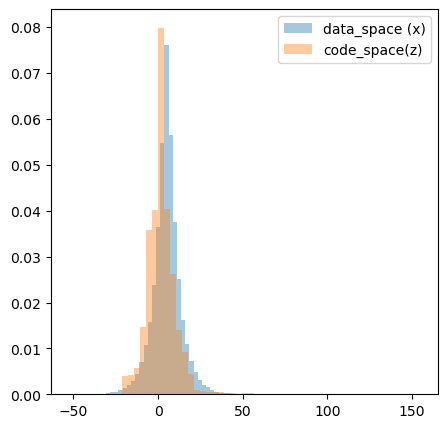

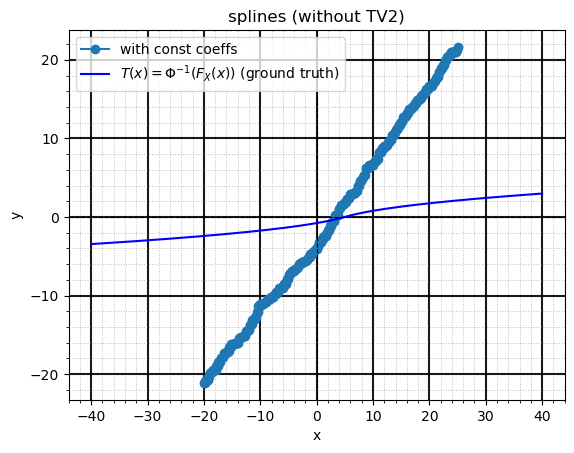

In [12]:
# Creating an Ensemble of Models

NUM_ENSEMBLE = 1
# laplace distn case
models_list = [
    ModelTrainer(size=SIZE, range_=RANGE, start_val=START_VAL, end_val=END_VAL,wtd_tv2=1, weights=wts,
                 GRID_VALS=GRID_VALS, FN_INIT=FN_INIT, mu=mu, b=b)
    for _ in range(NUM_ENSEMBLE)
] 

#PLOT CONDITION BEFORE THE TRAINING
for i in range(NUM_ENSEMBLE):
    models_list[i].before_training_plot(train_data=train_data, mu=mu, b=b)

In [18]:
# training the ensemble of models

ensemble_results = {}# dictionary to store results

# Number of models in the ensemble
num_models = NUM_ENSEMBLE

# Train each model and store results
for i in range(num_models):
    print(f"Training model {i+1}/{num_models}...")

    # Train the model
    train_loss, val_loss, epoch_wise_param_list, coeffs_unconstrained, coeffs_const = models_list[i].train_and_evaluate(
        train_loader=train_loader,
        val_loader=val_loader, 
        num_epochs=15, 
        scheduler_type="ReduceLROnPlateau",
        lr=0.0005,
        print_after=1,   
        track_coefficients=1,
        type_model="scls", 
        tv2_regulation=1, 
        lambda_tv2=0.000065, 
        gamma=0.5, 
        alpha_nll=1
    )

    # Store results in dictionary
    ensemble_results[i] = {
        "model trained" : models_list[i],
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_wise_params": epoch_wise_param_list,
        "coeffs_unconstrained": coeffs_unconstrained,
        "coeffs_const": coeffs_const
    }

print("Training complete! Ensemble results stored.")


Training model 1/1...


Training Progress:   7%|▋         | 1/15 [00:52<12:15, 52.54s/it]

Epoch 1/15, train NLL+6.5e-05XTV2: 3.324922037864709, data avg loss-1: 0.5206415809075452, data avg loss-2: -2.8042271216260257, Training NLL Loss: 3.324868702533566, Validation NLL Loss: 3.4005610794091847, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [01:45<11:24, 52.62s/it]

Epoch 2/15, train NLL+6.5e-05XTV2: 3.3586597503450655, data avg loss-1: 0.5208826327338618, data avg loss-2: -2.837723162712221, Training NLL Loss: 3.358605795446075, Validation NLL Loss: 3.3722725142517915, LR: 0.0005


Training Progress:  20%|██        | 3/15 [02:37<10:29, 52.50s/it]

Epoch 3/15, train NLL+6.5e-05XTV2: 3.3342704403670744, data avg loss-1: 0.49492885149044125, data avg loss-2: -2.839284623188432, Training NLL Loss: 3.334213474678863, Validation NLL Loss: 3.354608695055257, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [03:30<09:38, 52.61s/it]

Epoch 4/15, train NLL+6.5e-05XTV2: 3.3393964544884653, data avg loss-1: 0.48649842631001966, data avg loss-2: -2.8528422557333153, Training NLL Loss: 3.3393406820433293, Validation NLL Loss: 3.4077000731920855, LR: 0.00025


Training Progress:  33%|███▎      | 5/15 [04:22<08:42, 52.27s/it]

Epoch 5/15, train NLL+6.5e-05XTV2: 3.320964689047874, data avg loss-1: 0.4562363370358504, data avg loss-2: -2.8646789422337595, Training NLL Loss: 3.3209152792696175, Validation NLL Loss: 3.352590572285698, LR: 0.00025


Training Progress:  40%|████      | 6/15 [05:14<07:51, 52.43s/it]

Epoch 6/15, train NLL+6.5e-05XTV2: 3.2854509524934605, data avg loss-1: 0.4541120662384779, data avg loss-2: -2.8312927925824916, Training NLL Loss: 3.2854048588209657, Validation NLL Loss: 3.3316523607166926, LR: 0.00025


Training Progress:  47%|████▋     | 7/15 [06:07<07:01, 52.68s/it]

Epoch 7/15, train NLL+6.5e-05XTV2: 3.304156866059477, data avg loss-1: 0.4672338879331036, data avg loss-2: -2.836873288045513, Training NLL Loss: 3.3041071759786225, Validation NLL Loss: 3.282032779325821, LR: 0.00025


Training Progress:  53%|█████▎    | 8/15 [07:00<06:08, 52.60s/it]

Epoch 8/15, train NLL+6.5e-05XTV2: 3.2478656952377065, data avg loss-1: 0.4460352958877907, data avg loss-2: -2.8017821788204387, Training NLL Loss: 3.247817474708231, Validation NLL Loss: 3.2853040938421243, LR: 0.00025


Training Progress:  60%|██████    | 9/15 [07:53<05:16, 52.78s/it]

Epoch 9/15, train NLL+6.5e-05XTV2: 3.2638039582460077, data avg loss-1: 0.4501506916646508, data avg loss-2: -2.813602525994656, Training NLL Loss: 3.2637532176593114, Validation NLL Loss: 3.335725423181935, LR: 0.00025


Training Progress:  67%|██████▋   | 10/15 [08:47<04:25, 53.03s/it]

Epoch 10/15, train NLL+6.5e-05XTV2: 3.298162394858701, data avg loss-1: 0.45778301322384957, data avg loss-2: -2.8403267585772958, Training NLL Loss: 3.2981097718011436, Validation NLL Loss: 3.407413486453104, LR: 0.00025


Training Progress:  73%|███████▎  | 11/15 [09:38<03:30, 52.58s/it]

Epoch 11/15, train NLL+6.5e-05XTV2: 3.274146865991285, data avg loss-1: 0.4707199858575027, data avg loss-2: -2.8033752747978338, Training NLL Loss: 3.274095260655333, Validation NLL Loss: 3.2918528321700595, LR: 0.000125


Training Progress:  80%|████████  | 12/15 [10:31<02:38, 52.69s/it]

Epoch 12/15, train NLL+6.5e-05XTV2: 3.304664941000443, data avg loss-1: 0.4482445414707236, data avg loss-2: -2.8563666985344747, Training NLL Loss: 3.3046112400051966, Validation NLL Loss: 3.3681325814302454, LR: 0.000125


Training Progress:  87%|████████▋ | 13/15 [11:23<01:45, 52.55s/it]

Epoch 13/15, train NLL+6.5e-05XTV2: 3.2813331302605104, data avg loss-1: 0.44904218922345385, data avg loss-2: -2.8322385763073727, Training NLL Loss: 3.2812807655308283, Validation NLL Loss: 3.3420374364437766, LR: 0.000125


Training Progress:  93%|█████████▎| 14/15 [12:16<00:52, 52.58s/it]

Epoch 14/15, train NLL+6.5e-05XTV2: 3.3013726198462003, data avg loss-1: 0.4407548298855495, data avg loss-2: -2.86056748991835, Training NLL Loss: 3.301322319803902, Validation NLL Loss: 3.3538194036558675, LR: 6.25e-05


Training Progress: 100%|██████████| 15/15 [13:08<00:00, 52.57s/it]

Epoch 15/15, train NLL+6.5e-05XTV2: 3.296223137405311, data avg loss-1: 0.435052168819997, data avg loss-2: -2.8611232343644017, Training NLL Loss: 3.296175403184395, Validation NLL Loss: 3.3134308223246114, LR: 6.25e-05
Training complete
Training complete! Ensemble results stored.


In [21]:
def analyse_ensemble_training(ensemble_results, model_indices="all", figsize=(20, 20), plot_freq=1, style='-*'):
    """
    NOTE: THERE IS SOME MISTAKE IN THIS CODE, NEED TO FIX IT LATER!
    Analyse the training performance of an ensemble of models.

    Parameters:
    - ensemble_results (dict): Dictionary containing training data for each model.
    - model_indices (int, list, or "all"): 
        - If "all", analyzes all models.
        - If an int, analyzes a specific model (e.g., 1 for "model_1").
        - If a list, analyzes multiple specific models.
    - figsize (tuple): Figure size for plots.
    - plot_freq (int): Frequency of epochs to plot.

    """
    # Handle cases for model selection
    if model_indices == "all":
        selected_models = ensemble_results.keys()  # All models
    elif isinstance(model_indices, int):
        selected_models = [model_indices]  # Single model
    elif isinstance(model_indices, list):
        selected_models = model_indices  # Multiple models
    else:
        raise ValueError("model_indices must be 'all', an integer, or a list of integers.")

    # Analyze each selected model
    for model_key in selected_models:
        if model_key not in ensemble_results:
            print(f"Warning: {model_key} not found in ensemble results. Skipping...")
            continue

        model_data = ensemble_results[model_key]

        print(f"Analyzing {model_key}...")

        # Call the original analyze function for each model
        analyse_training(
            model_in=models_list[model_key].model, 
            train_loss=model_data["train_loss"],
            val_loss=model_data["val_loss"],
            test_data=test_data,
            figsize=figsize,
            model_params_list=model_data["epoch_wise_params"],
            num_coeffs=10,
            size=SIZE,
            range=RANGE,
            print_model_params=0,
            plot_freq=plot_freq,
            mu=mu,
            b=b,
            style=style
        )
        print(f"Completed analysis for {model_key}.\n")

Analyzing 0...


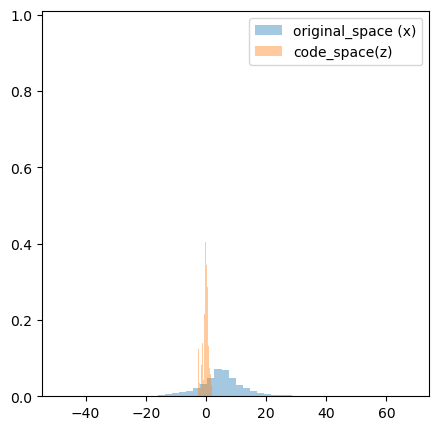

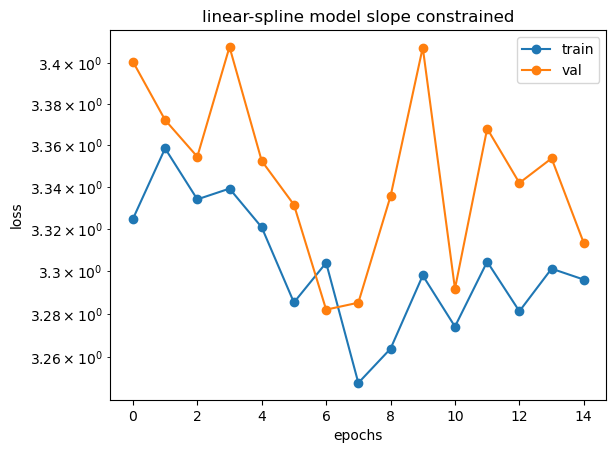

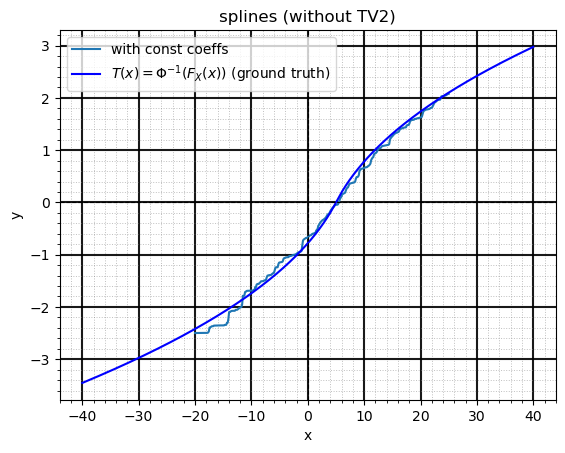

/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


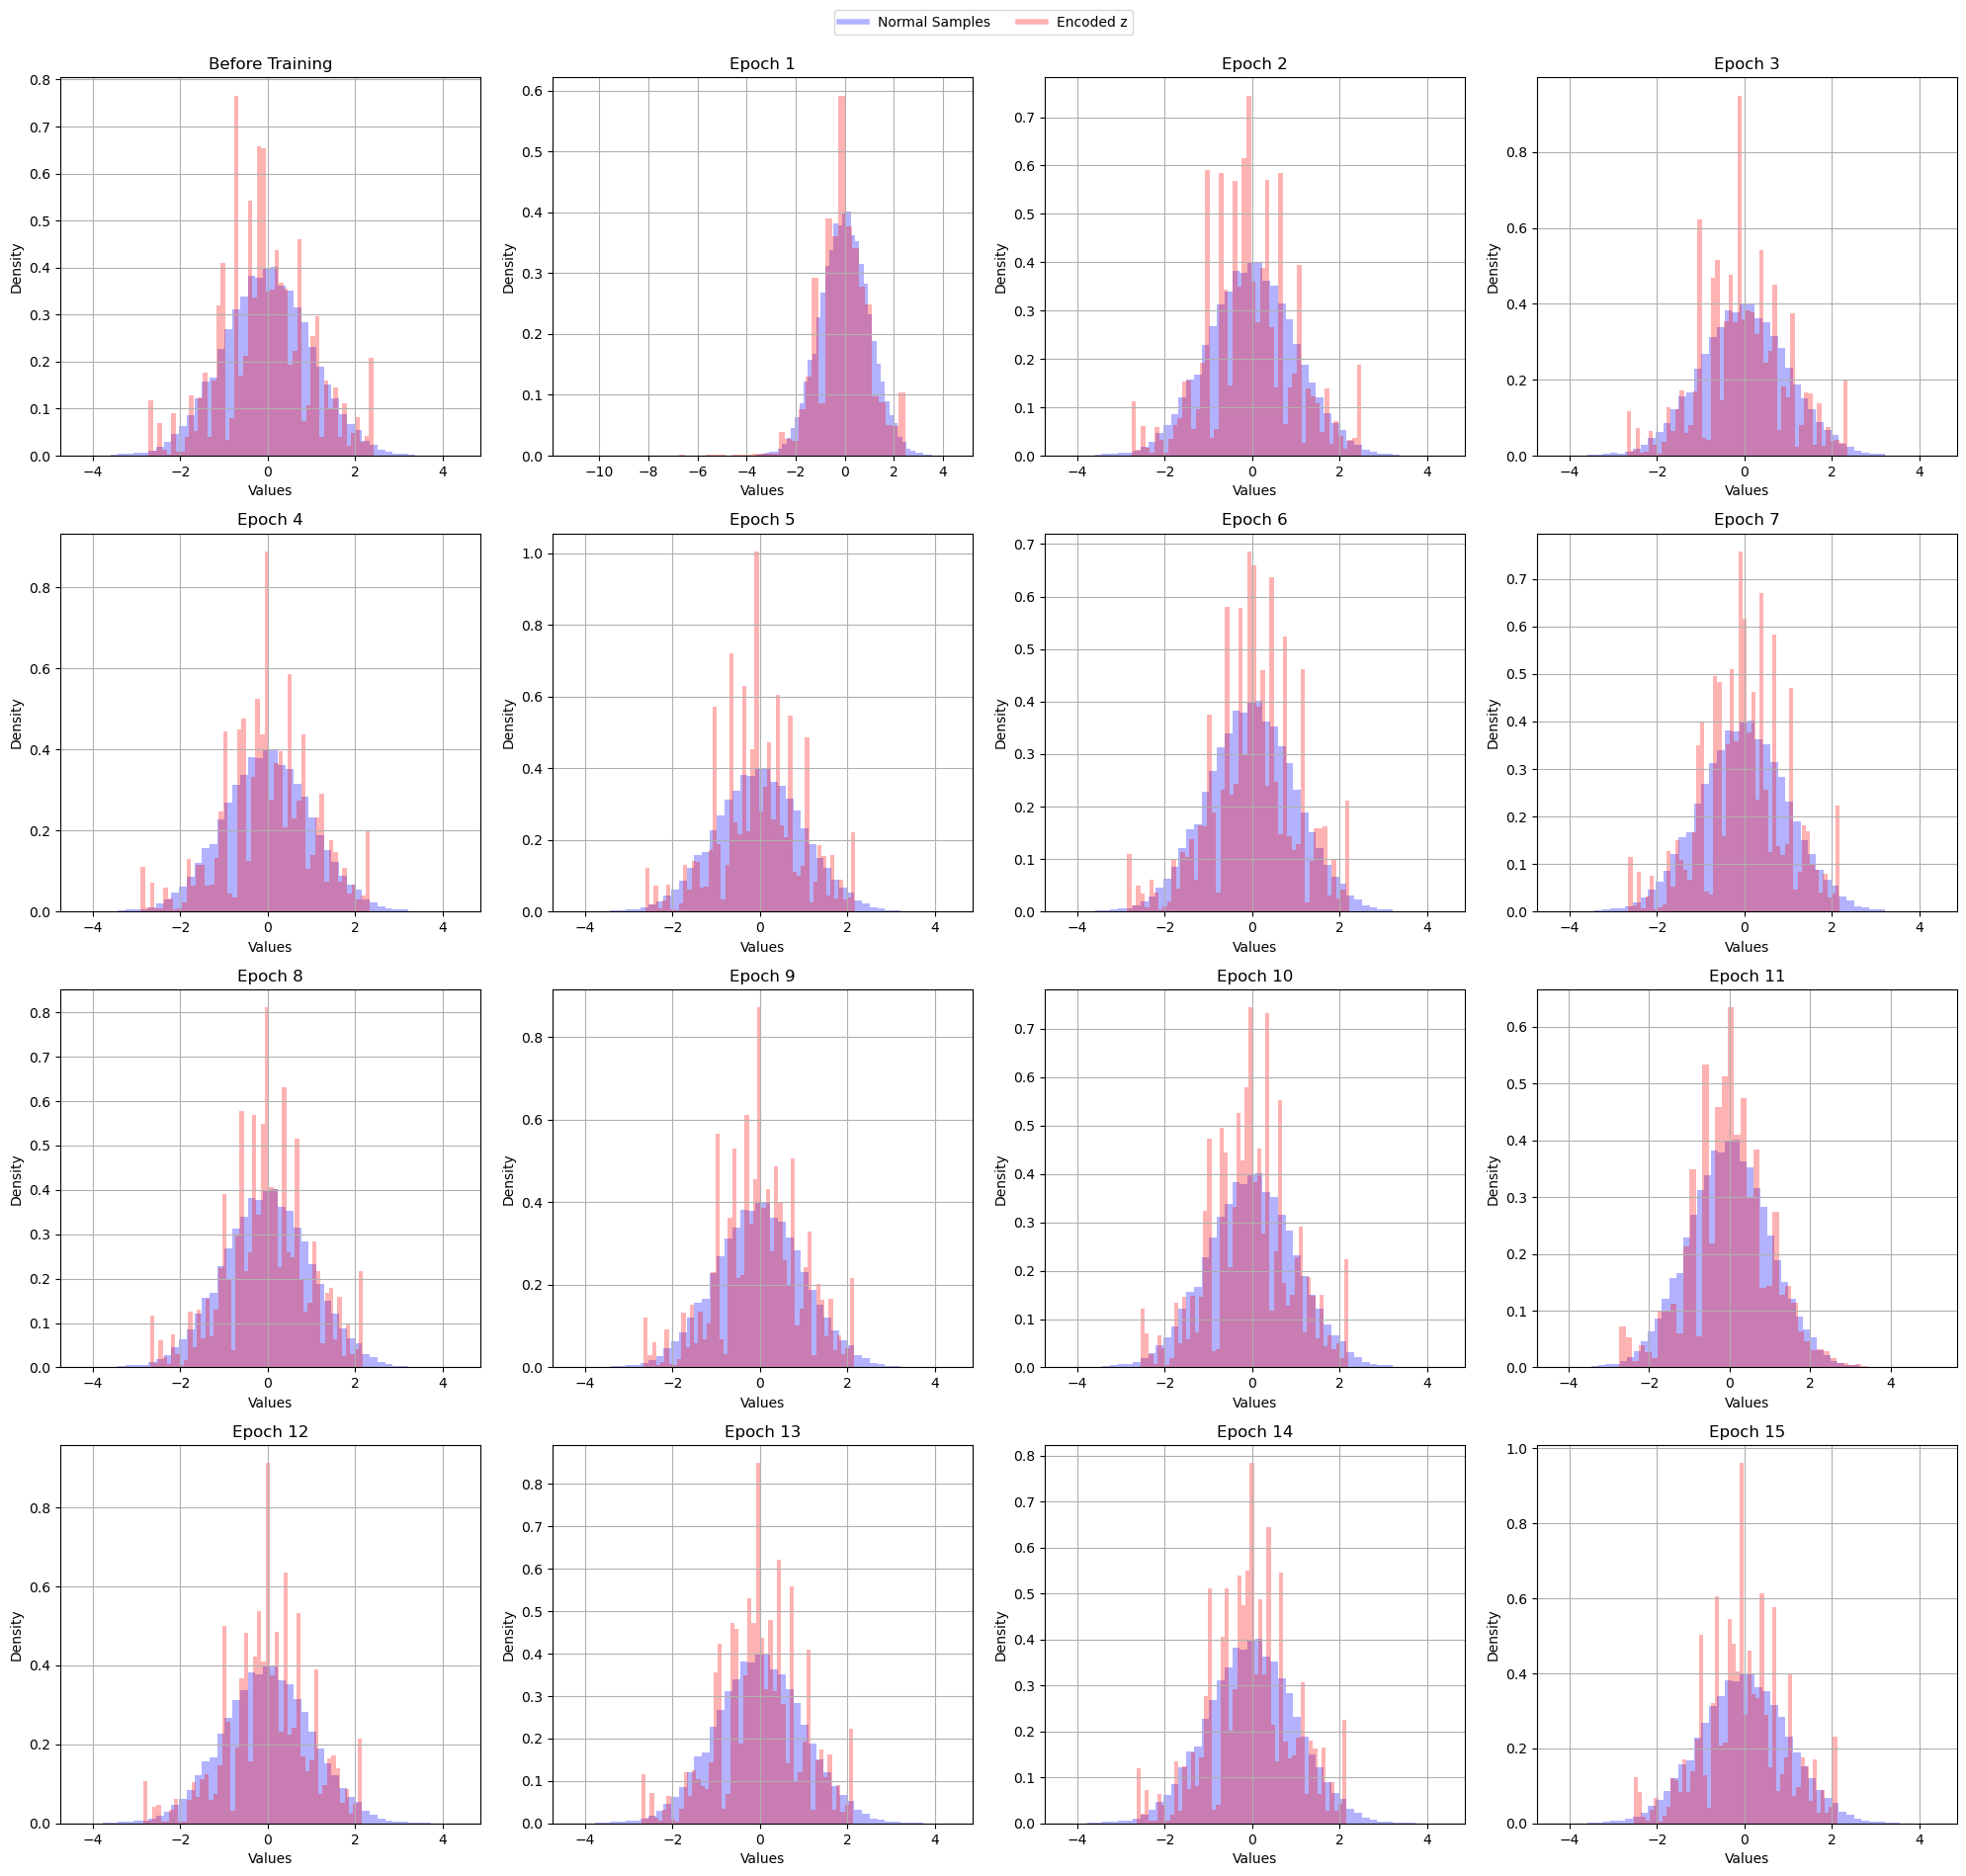

Completed analysis for 0.



In [22]:
# Analyze all models
analyse_ensemble_training(ensemble_results, model_indices="all", style='-')

# # Analyze a single model (e.g., model_3)
# analyse_ensemble_training(ensemble_results, model_indices=3)

# # Analyze specific models (e.g., model_1 and model_4)
# analyse_ensemble_training(ensemble_results, model_indices=[1, 4])

In [16]:
torch.save(ensemble_results,'ensemble_results_weighted_reduced.pth')
# in ensemble_results_weighted.pth, i chose the tv2 regul value to be 0.000095
# in ensemble_results_weighted_reduced, i want to go back to original tv2 strength of 0.000065.

In [17]:
torch.save(models_list, 'models_list_wtd_reduced.pth')

In [18]:
# from scipy.stats import norm
# def plot_with_annotations(x, y,label="with const coeffs",
#                 title="Plot with (x, y) Annotations", 
#             xlabel="X-axis", ylabel="Y-axis",
#             txt_color="red", annotate=1, style="-o", want_legend_now=1,
#             **kwargs):
#     """
#     Plot x and y values with (x, y) annotations.

#     Args:
#     - x (array-like): Array of x-values.
#     - y (array-like): Array of y-values.
#     - title (str): Title of the plot.
#     - xlabel (str): Label for the X-axis.
#     - ylabel (str): Label for the Y-axis.

#     Returns:
#     - None
#     """
#     plt.plot(x, y, style,label=label)  # Plot the points with markers and lines

#     # Annotate each point with its (x, y) coordinates
#     if annotate:
#         for x_val, y_val in zip(x, y):
#             plt.annotate(
#                 f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
#                 (x_val, y_val),  # The point to annotate
#                 textcoords="offset points",  # Offset the text slightly
#                 xytext=(5, 5),  # Offset (5, 5) pixels
#                 fontsize=8,  # Font size of the annotation
#                 color=txt_color # Optional: text color
#             )
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.grid(which='both')  # Optional: Add a grid
#     plt.minorticks_on()

#     # # Define x values
#     ## Note FOR ME: I NEED TO FIGURE OUT WHAT IS MU AND B IN THE NOTEBOOK. 
#     # I HAD DEFINED MU AND B AS GLOBAL PARAMTERS, = MEAN AND SCALE
#     x = np.linspace(-40, 40, 1000)

#     # Check if both mu and b are provided in kwargs
#     if 'mu' in kwargs and 'b' in kwargs:
#         # Extract mu and b from kwargs with default values
#         mu = kwargs.get('mu', 0)  # Default mu = 0
#         b = kwargs.get('b', 1)    # Default b = 1

#         # Compute Laplace CDF
#         F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

#         # Compute the transformation function T(x)
#         T_x = norm.ppf(F_X)

#         # Plot T(x)
#         plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$ (analytical solution)', color='b')

#     # Bold major grid lines
#     plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

#     # Light minor grid lines
#     plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
#     plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
#     plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
#     plt.legend()

In [52]:
# plotting a common average curve
def plot_common_model(models_list, conf_level=1):

    # collect x and y values and then take the average and std deviation. then simply  plot  them along with the true value

    # Extract x values from the first model (same for all models)
    xpos = models_list[0].model.nodal_val_loc_tensor.detach().numpy()

    # Extract y values from all models
    y_values = np.array([trainer.model.slope_constrained_coefficients_vect.detach().numpy() for trainer in models_list])

    # mean and std deviation
    y_mean = np.mean(y_values, axis=0)
    y_std = np.std(y_values, axis=0)

    plot_with_annotations(x=xpos[0], y=y_mean,annotate=0,mu=mu, b=b,label= 'mean spline from training', style='-' , want_legend_now=0,
                          title= 'plotting  mean splines, mean taken over 10 models')
    plt.fill_between(xpos[0], y_mean - conf_level*y_std, y_mean + conf_level*y_std, color='b',  alpha=0.3, label=f"{conf_level} x Std deviation")
    plt.legend()



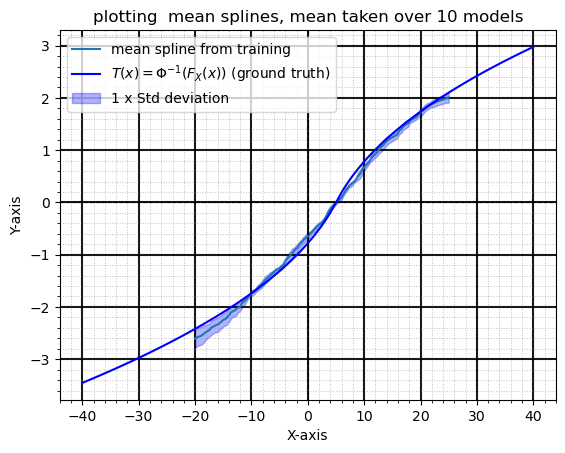

In [ ]:
data=models_list
plot_common_model(data)

In [57]:
# loading unweighted ones:
models_unwtd= torch.load('models_list.pth')

/tmp/ipykernel_80589/893154476.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_unwtd= torch.load('models_list.pth')


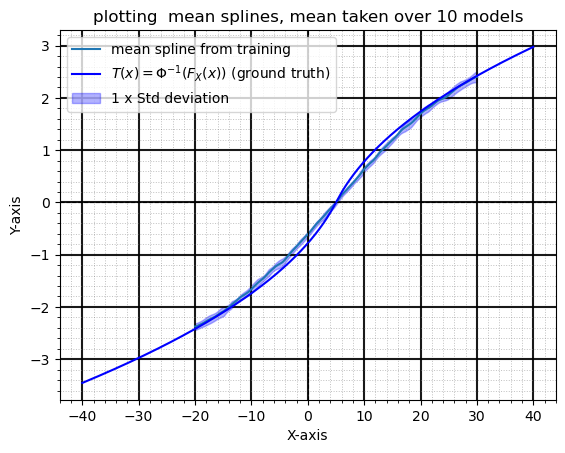

In [ ]:
plot_common_model(models_unwtd)